# 🚢 **Titanic Survival Prediction**

In [613]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

plt.style.use('bmh')
sns.set_context('notebook')
set_matplotlib_formats('retina')
warnings.filterwarnings('ignore')

In [614]:
SEED = 42
np.random.seed(SEED)

# Exploratory Data Analysis

In [615]:
home_dir = 'titanic/'
train_df = pd.read_csv(home_dir + 'train.csv')
test_df = pd.read_csv(home_dir + 'test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [616]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- **object cols**: Name, Sex, Ticket, Cabin, Embarked
- **numeric cols**: PassengerId, Pclass, Age, SibSp, Parch, Fare

## Handel Missing Values

In [617]:
# the zip function unpacks 2 pandas
# series 1 of the test_df nulls and the other of the train_df nulls into ordered tuples
def nulls_df(train_df, test_df):
    return pd.DataFrame(
        columns=['Train Nulls', 'Test Nulls'], 
        data=zip(train_df.drop('Survived', axis=1).isna().sum(axis=0), test_df.isna().sum(axis=0)),
        index=test_df.columns
    )
nulls_df(train_df, test_df).T

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Train Nulls,0,0,0,0,177,0,0,0,0,687,2
Test Nulls,0,0,0,0,86,0,0,0,1,327,0


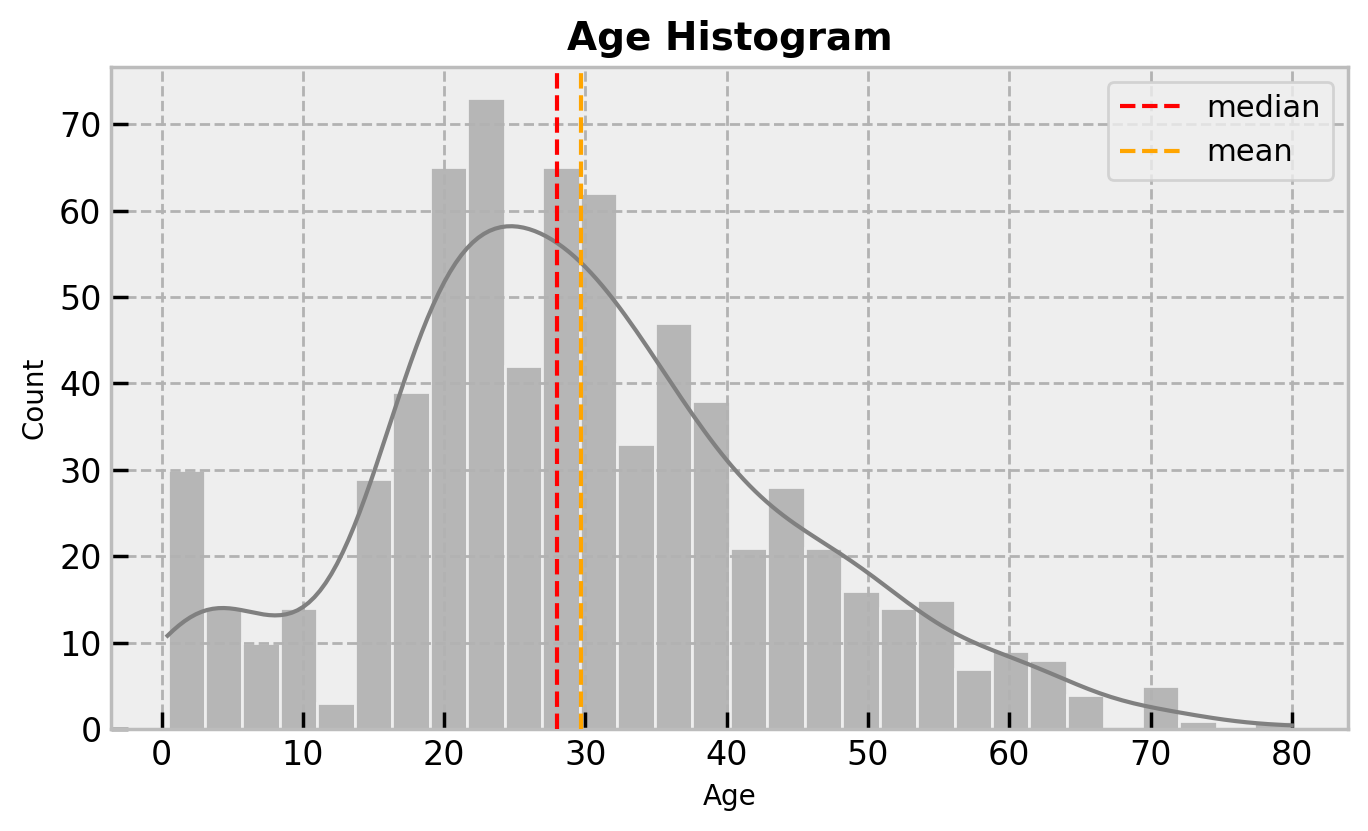

In [618]:
fig = plt.figure(figsize=(7, 4.3))

sns.histplot(
    data=train_df['Age'], kde=True, bins=30, zorder=1, color='grey'
)
plt.axvline(
    x=train_df.Age.median(), color='red', linestyle='--', label='median', zorder=3
)
plt.axvline(
    x=train_df.Age.mean(), color='orange', linestyle='--', label='mean', zorder=3
)

plt.title('Age Histogram', fontsize=14, weight='bold')
plt.xlabel('Age', fontsize=10), plt.ylabel('Count', fontsize=10)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)

plt.tight_layout()
plt.legend()
plt.show()

In [619]:
# fill missing ages with the median age
train_df['Age'].fillna(train_df.Age.median(), inplace=True)
test_df['Age'].fillna(train_df.Age.median(), inplace=True)
nulls_df(train_df, test_df).loc['Age'] == 0

Train Nulls    True
Test Nulls     True
Name: Age, dtype: bool

In [620]:
train_df[train_df.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


both females survived and have missing embark values so they probably did not embark

In [621]:
train_df.drop(train_df[train_df.Embarked.isna()].index, axis=0, inplace=True)

In [622]:
nulls_df(train_df, test_df).loc['Embarked'] == 0

Train Nulls    True
Test Nulls     True
Name: Embarked, dtype: bool

In [623]:
test_df.Fare.fillna(0, axis=0, inplace=True)
nulls_df(train_df, test_df).loc['Fare'] == 0

Train Nulls    True
Test Nulls     True
Name: Fare, dtype: bool

In [624]:
nulls_df(train_df, test_df).loc['Cabin']

Train Nulls    687
Test Nulls     327
Name: Cabin, dtype: int64

In [625]:
print(f'There {train_df.Cabin.str[0].nunique()} Decks on the Titanic {sorted(train_df.Cabin.str[0].value_counts().index)}')
print(f'There {train_df.Cabin.str[1:].nunique()} Unique Cabins in this Dataset')

There 8 Decks on the Titanic ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
There 101 Unique Cabins in this Dataset


in the titanic there are decks through A-G, i think T is a mistake so ill fill it also with U

## Feature Engineering

In [626]:
# create two new fdeature to make use of the Cabin feature
train_df['HasCabin'] = train_df.Cabin.notnull().astype(int)
test_df['HasCabin'] = test_df.Cabin.notnull().astype(int)

# fill all nulls with U for Unknown
train_df.Cabin.fillna('U', inplace=True)
train_df.loc[train_df.Cabin.str[0] == 'T', 'Cabin'] = 'U'

test_df.Cabin.fillna('U', inplace=True)
test_df.loc[test_df.Cabin.str[0] == 'T', 'Cabin'] = 'U'

# Replace the Cabin column with Deck containing only the deck name for each cabin
train_df['Deck'] = train_df.Cabin.str[0]
test_df['Deck'] = test_df.Cabin.str[0]

# Calculating the amount of Relatives on board for each border
train_df['Relatives'] = train_df.SibSp + train_df.Parch
test_df['Relatives'] = test_df.SibSp + test_df.Parch

In [627]:
# check manipulation
print(f"""
 - There {train_df.Deck.nunique()-1} Decks on the Titanic {sorted(train_df.Deck.value_counts().index)} and U for Unknown
 - In the Train Set Are {train_df.HasCabin.sum()}/{train_df.shape[0]} Pepole With a Cabin
 - In the Test Set Are {test_df.HasCabin.sum()}/{test_df.shape[0]} Pepole With a Cabin
""")


 - There 7 Decks on the Titanic ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U'] and U for Unknown
 - In the Train Set Are 202/889 Pepole With a Cabin
 - In the Test Set Are 91/418 Pepole With a Cabin



## Encoding Features

In [628]:
# Regular lable encoding for male/female --> 1/0
train_df.Sex = train_df.Sex.map({'male': 1, 'female': 0})
test_df.Sex = test_df.Sex.map({'male': 1, 'female': 0})

### Ticket Prefix Extraction and Target Encoding

In [629]:

# picking out the start prefix of each ticket
train_df['TicketPrefix'] = train_df.Ticket.str.extract(r'(^[A-Za-z./]+)').fillna('None')
test_df['TicketPrefix'] = test_df.Ticket.str.extract(r'(^[A-Za-z./]+)').fillna('None')

# leave one out target encoding the different prefixes
from sklearn.preprocessing import TargetEncoder
loo_encoder = TargetEncoder(target_type='binary', cv=train_df.shape[0])
loo_encoder.fit(train_df[['TicketPrefix']], train_df['Survived'])

train_df[['TicketPrefix']] = loo_encoder.transform(train_df[['TicketPrefix']])
test_df[['TicketPrefix']] = loo_encoder.transform(test_df[['TicketPrefix']])

In [630]:
print(f"""- Went down from {train_df.Ticket.nunique()} to {train_df.TicketPrefix.nunique()} Unique Values After Prefix Extraction""")

- Went down from 680 to 16 Unique Values After Prefix Extraction


### Name-Title Regex Manipulation

In [631]:
# titles to titles mapping for less features
title_mapping = {
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Ms': 'Ms',
    'Master': 'Master',
    'Dr': 'Dr',
    'Rev': 'Rev',
    'Col': 'Officer',
    'Major': 'Officer',
    'Capt': 'Officer',
    'Sir': 'Noble',
    'Lady': 'Noble',
    'Countess': 'Noble',
    'Don': 'Mr',
    'Dona': 'Mrs',
    'Mlle': 'Miss',
    'Mme': 'Mrs',
    'Jonkheer': 'Noble'
}
# extracting the title for each name
train_df['Title'] = train_df.Name.str.extract(r'([A-Z]\w*(?=\.))')
test_df['Title'] = test_df.Name.str.extract(r'([A-Z]\w*(?=\.))')

# mapping the title map to the all extracted titles
train_df.Title = train_df.Title.map(title_mapping).fillna('NoTitle')
test_df.Title = test_df.Title.map(title_mapping).fillna('NoTitle')

In [632]:
print(f"""- Found {train_df.Title.nunique()-1} Titles in Boarders Names {sorted(train_df.Title.value_counts().index)}""")

- Found 8 Titles in Boarders Names ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Ms', 'Noble', 'Officer', 'Rev']


### One Hot Label Encoding

In [633]:
# One Hot Label Encoding on Title, Deck, Embarked.
train_df = pd.get_dummies(
    train_df,
    dtype=int,
    columns=['Title', 'Deck', 'Embarked'],
    prefix={'Title': '', 'Deck': 'Deck', 'Embarked': 'Port'}, 
    prefix_sep={'Title': '', 'Deck': '-', 'Embarked': '-'}
    )

test_df = pd.get_dummies(
    test_df,
    dtype=int,
    columns=['Title', 'Deck', 'Embarked'],
    prefix={'Title': '', 'Deck': 'Deck', 'Embarked': 'Port'}, 
    prefix_sep={'Title': '', 'Deck': '-', 'Embarked': '-'}
    )

In [634]:
for column in train_df.drop('Survived', axis=1).columns:
    if column not in test_df.columns:
        train_df.drop(column, axis=1, inplace=True)
        # test_df[column] = np.zeros(test_df.shape[0])
        # print(test_df[column].head(3).to_frame())
        print(f'Dropping: {column}. it was not found in test set')

Dropping: Noble. it was not found in test set


In [635]:
# dropping all redundent columns after feature encoding and engineering
train_df.drop(['Cabin', 'SibSp', 'Parch', 'Ticket', 'Name'], axis=1, inplace=True)
test_df.drop(['Cabin', 'SibSp', 'Parch', 'Ticket', 'Name'], axis=1, inplace=True)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,HasCabin,Relatives,TicketPrefix,Dr,...,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-U,Port-C,Port-Q,Port-S
0,1,0,3,1,22.0,7.2500,0,1,0.091213,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,1,0,38.0,71.2833,1,1,0.645773,0,...,0,1,0,0,0,0,0,1,0,0
2,3,1,3,0,26.0,7.9250,0,0,0.441042,0,...,0,0,0,0,0,0,1,0,0,1
3,4,1,1,0,35.0,53.1000,1,1,0.382398,0,...,0,1,0,0,0,0,0,0,0,1
4,5,0,3,1,35.0,8.0500,0,0,0.382398,0,...,0,0,0,0,0,0,1,0,0,1


## Look For Outliers

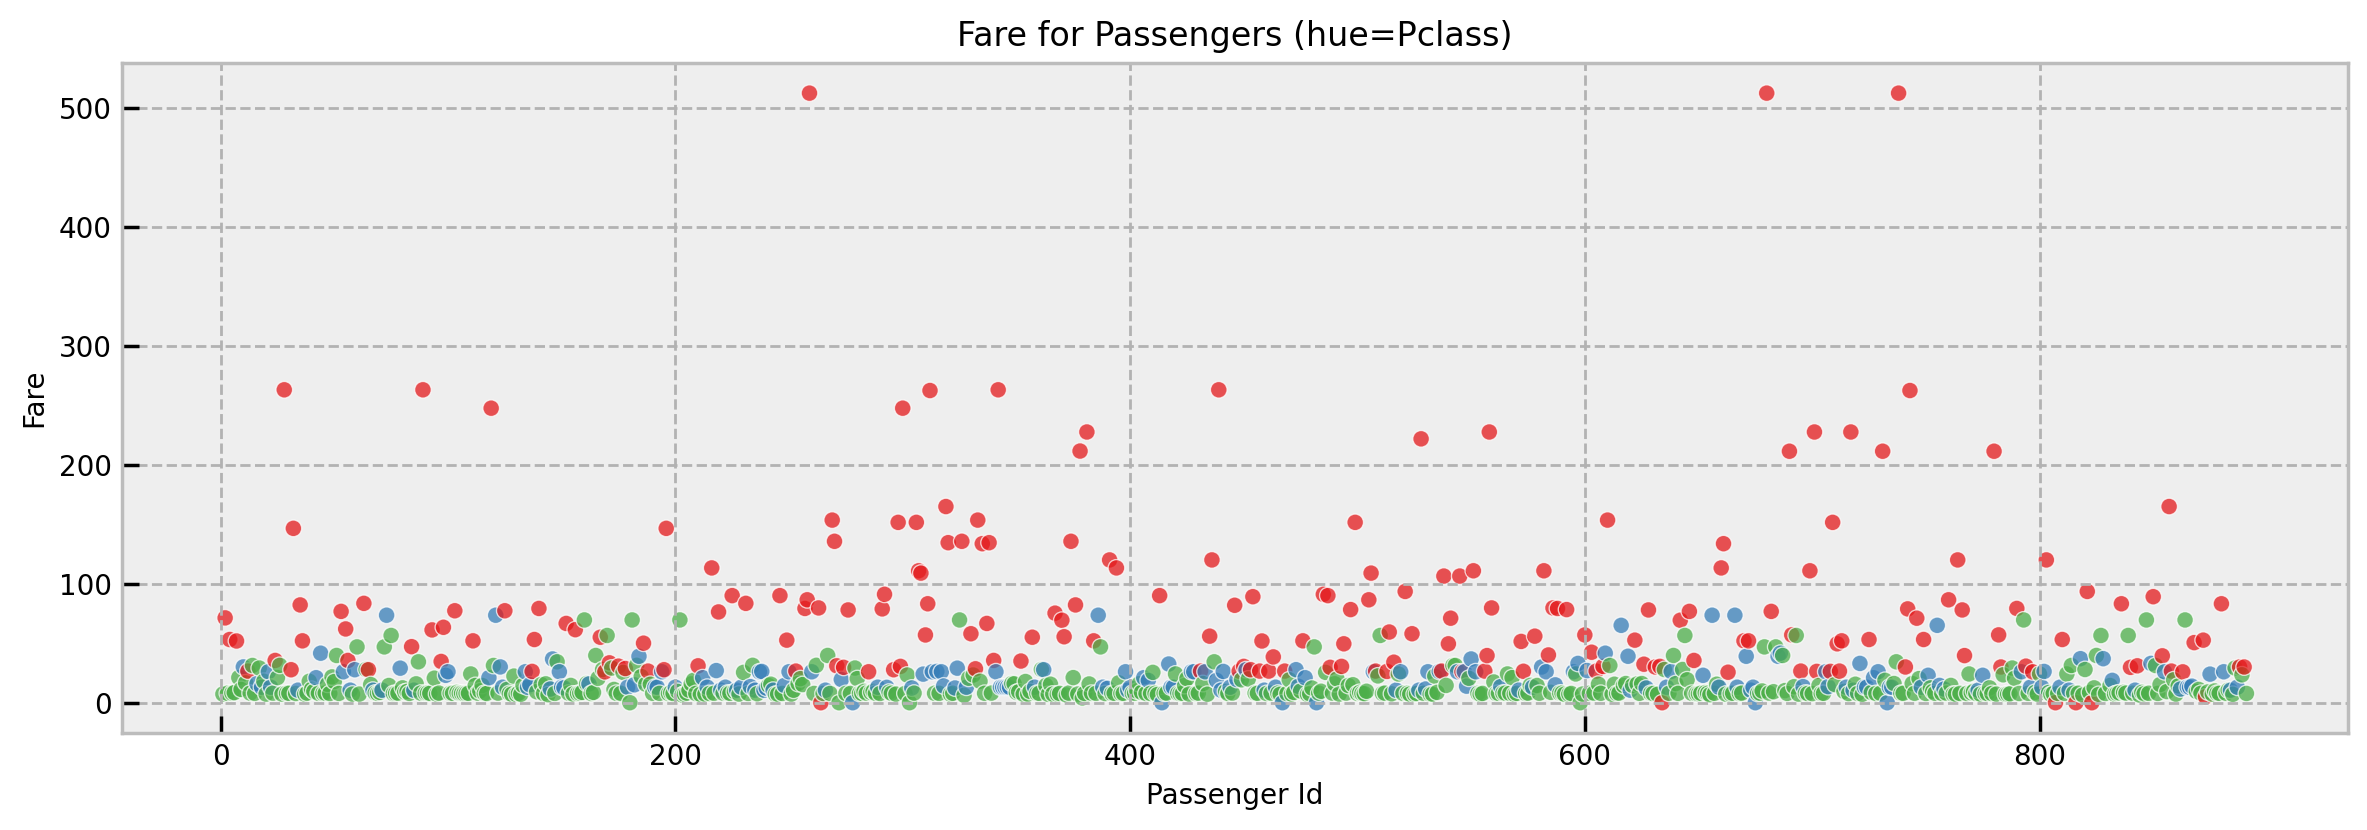

In [636]:
fig = plt.figure(figsize=(12, 4.3))
colors = sns.color_palette('Set1')

sns.scatterplot(
    x=train_df.PassengerId, y=train_df.Fare, 
    hue=train_df.Pclass, palette=colors, 
    alpha=0.75, legend=False
)

plt.title('Fare for Passengers (hue=Pclass)')
plt.xlabel('Passenger Id', fontsize=10), plt.ylabel('Fare', fontsize=10)
plt.xticks(fontsize=10), plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [637]:
# Remove top n extreme Fare values (identified as outliers from plot)
rows_to_remove = 3
indexes_to_remove = train_df.sort_values('Fare', ascending=False).iloc[:rows_to_remove].index
train_df = train_df.drop(indexes_to_remove, axis=0).reset_index(drop=True).copy()

# check top fare
train_df.sort_values('Fare', ascending=False).head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,HasCabin,Relatives,TicketPrefix,Dr,...,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-U,Port-C,Port-Q,Port-S
27,28,0,1,1,19.0,263.000,1,5,0.382398,0,...,0,1,0,0,0,0,0,0,0,1
339,342,1,1,0,24.0,263.000,1,5,0.382398,0,...,0,1,0,0,0,0,0,0,0,1
436,439,0,1,1,64.0,263.000,1,5,0.382398,0,...,0,1,0,0,0,0,0,0,0,1
87,89,1,1,0,23.0,263.000,1,5,0.382398,0,...,0,1,0,0,0,0,0,0,0,1
738,743,1,1,0,21.0,262.375,1,4,0.645773,0,...,1,0,0,0,0,0,0,1,0,0


In [638]:
train_df.drop('PassengerId', axis=1, inplace=True)
train_df.describe()

,Survived,Pclass,Sex,Age,Fare,HasCabin,Relatives,TicketPrefix,Dr,Master,...,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-U,Port-C,Port-Q,Port-S
count,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,...,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000
mean,0.380361,2.316027,0.648984,29.294774,30.470611,0.225734,0.908578,0.380648,0.007901,0.045147,...,0.048533,0.066591,0.037246,0.036117,0.014673,0.004515,0.775395,0.186230,0.086907,0.726862
std,0.485750,0.832607,0.477557,13.002157,41.155721,0.418301,1.616859,0.131252,0.088584,0.207743,...,0.215010,0.249454,0.189471,0.186688,0.120307,0.067077,0.417558,0.389512,0.281858,0.445823
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,7.895800,0.000000,0.000000,0.382398,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,28.000000,14.454200,0.000000,0.000000,0.382398,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,30.646850,0.000000,1.000000,0.382398,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,263.000000,1.000000,10.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


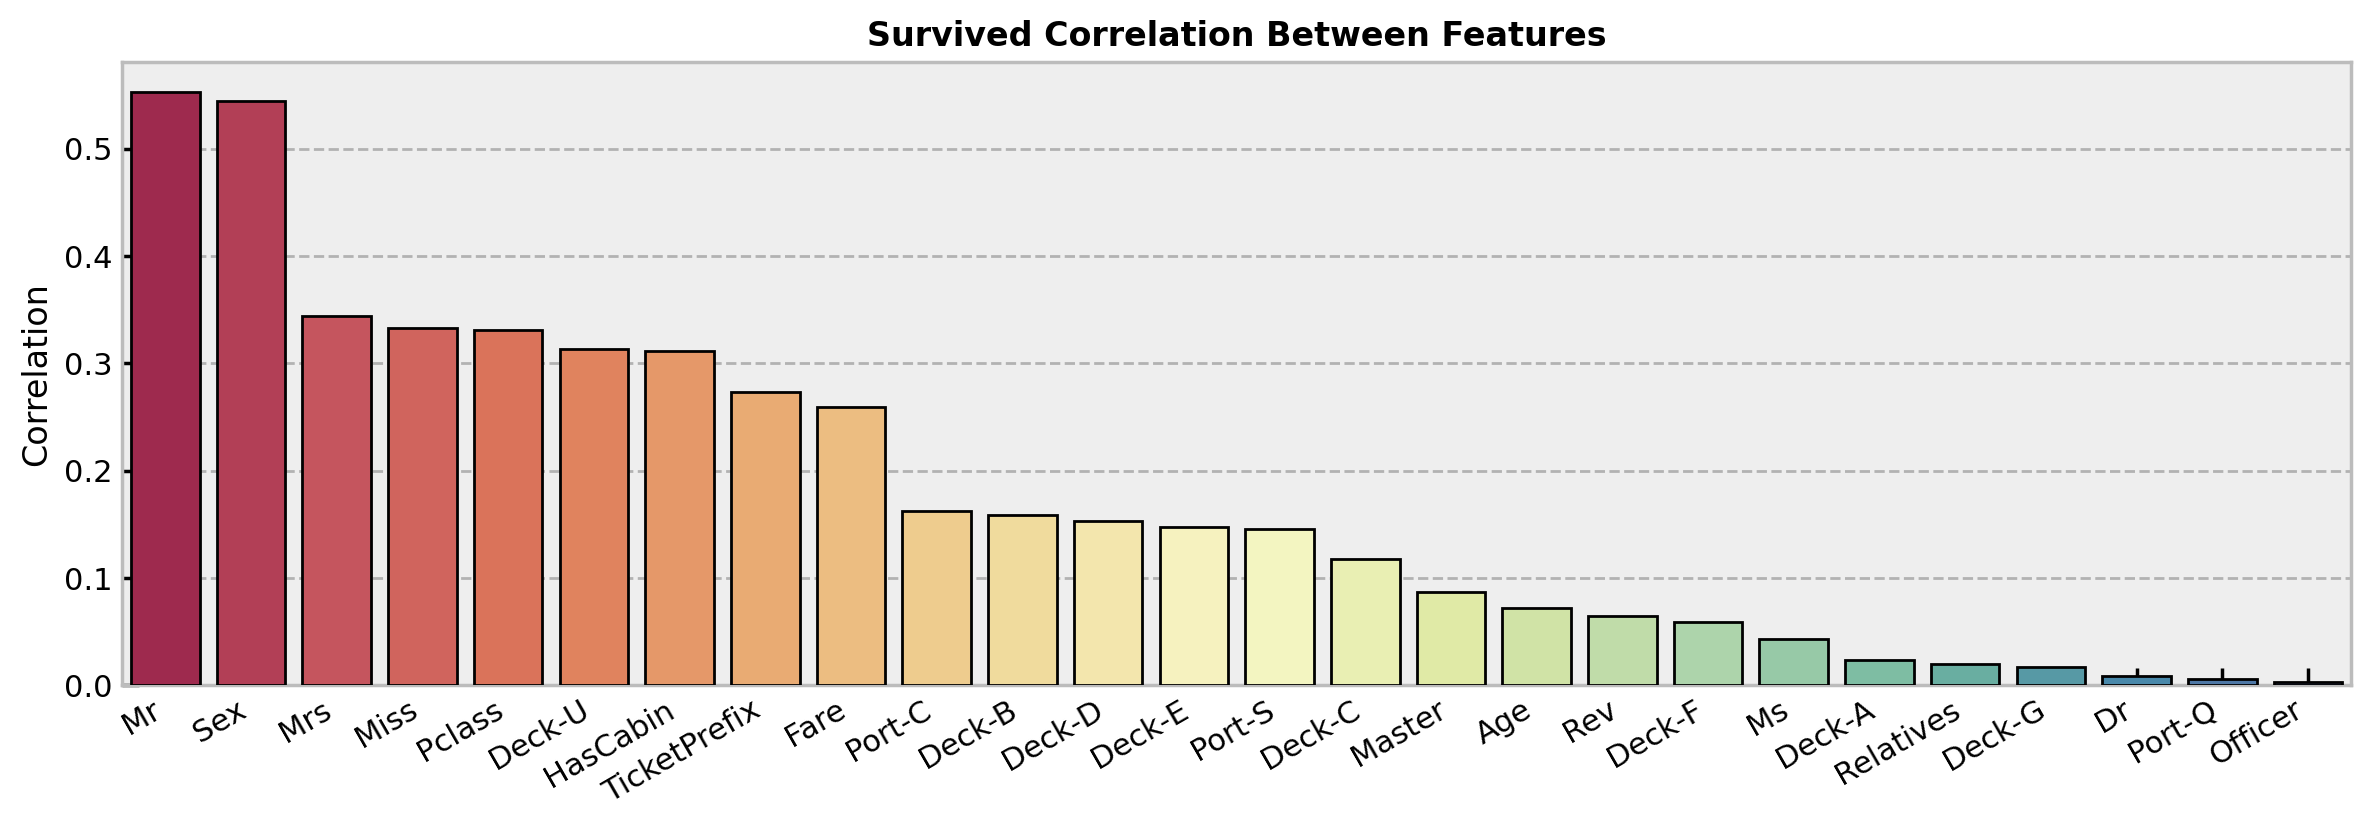

In [647]:
survival_corr_df = abs(train_df.corr().Survived)\
    .sort_values(ascending=False) \
    .to_frame().T \
    .drop('Survived', axis=1)

colors = sns.color_palette('Spectral', n_colors=survival_corr_df.shape[1])
fig = plt.figure(figsize=(12, 4.3))

sns.barplot(
    data=survival_corr_df, palette=colors, edgecolor='black', zorder=3, alpha=1
)

plt.title('Survived Correlation Between Features', fontsize=12, weight='bold')
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

# Training a Predictive Model

## Data Preperation

In [640]:
train_predictors = train_df.drop('Survived', axis=1).to_numpy().copy()
test_predictors = test_df.drop('PassengerId', axis=1).to_numpy().copy()
train_target = train_df.Survived.to_numpy().copy()


### Feature-Scaler Sampling

In [641]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

scalers = {
    'StandardScaler': StandardScaler, 
    'Normalizer': Normalizer, 
    'MinMaxScaler': MinMaxScaler, 
    'RobustScaler': RobustScaler
}
for name, feature_scaler in scalers.items():

    scelar_selector_pipe = Pipeline([
        ('scaler', feature_scaler()),
        ('model', LogisticRegression(random_state=SEED))
    ]) \
    .fit(train_predictors, train_target)

    preds = scelar_selector_pipe.predict(train_predictors)
    acc = accuracy_score(train_target, preds)
    prec = precision_score(train_target, preds)
    recl = recall_score(train_target, preds)
    f1 = f1_score(train_target, preds)

    print(f"""| {name:<14} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {recl:.4f} | F1: {f1:.4f} |""")


| StandardScaler | Accuracy: 0.8352 | Precision: 0.7903 | Recall: 0.7715 | F1: 0.7808 |
| Normalizer     | Accuracy: 0.6896 | Precision: 0.6260 | Recall: 0.4570 | F1: 0.5283 |
| MinMaxScaler   | Accuracy: 0.8431 | Precision: 0.8018 | Recall: 0.7804 | F1: 0.7910 |
| RobustScaler   | Accuracy: 0.8341 | Precision: 0.7896 | Recall: 0.7685 | F1: 0.7789 |


### Choosing Train/Validation Split

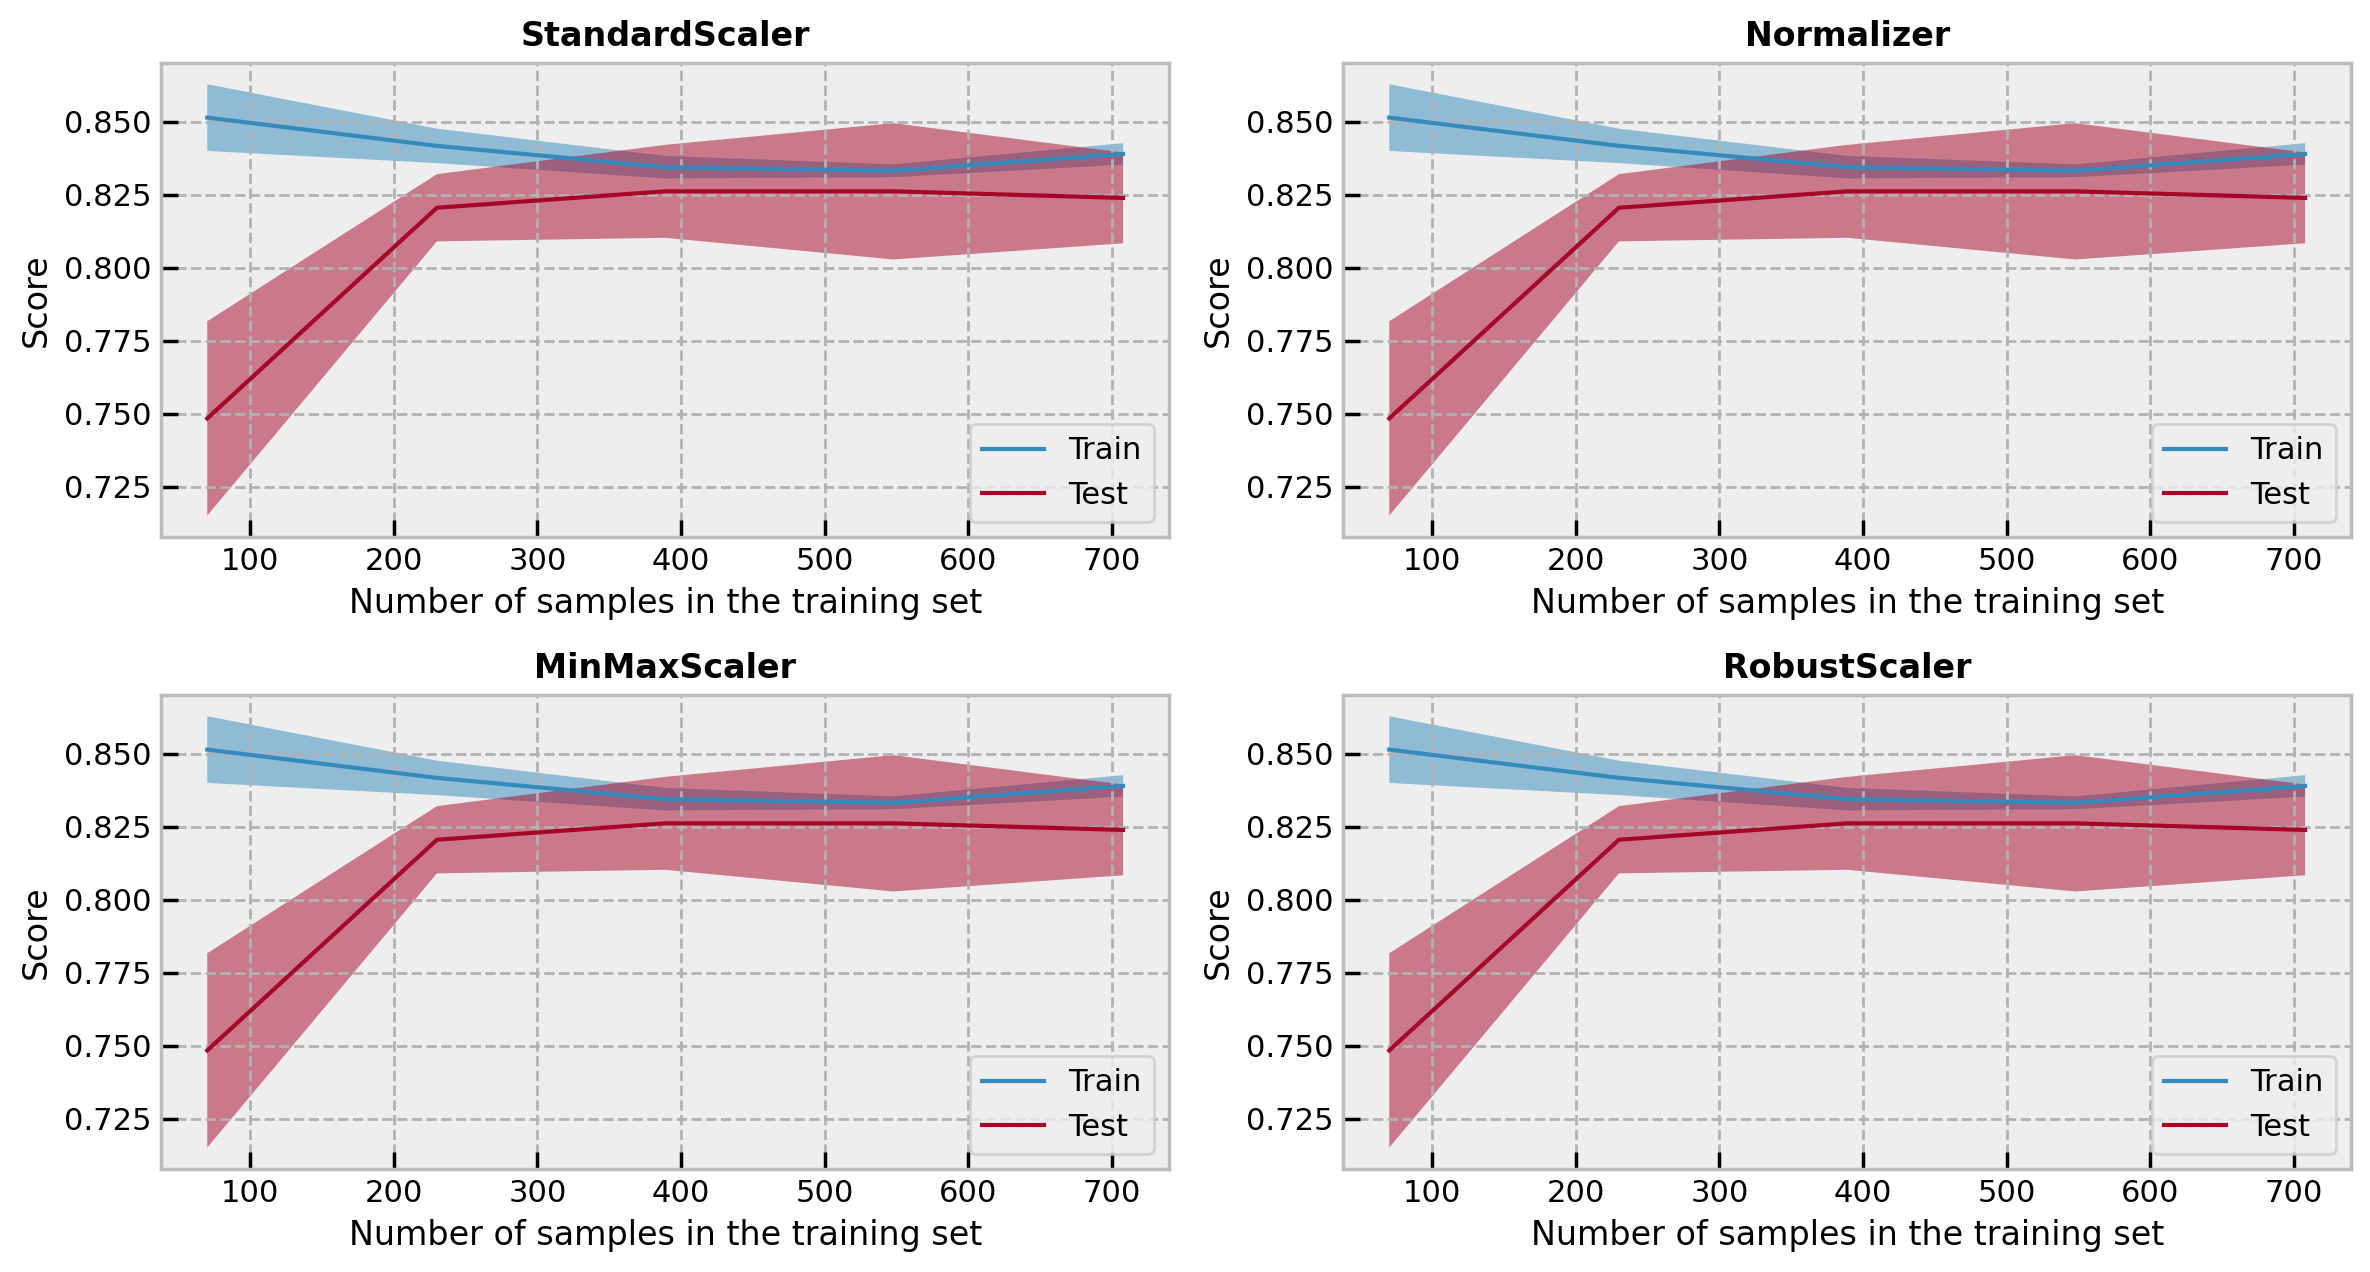

In [642]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve

# plot learning curves for different train subset choise
fig, axes = plt.subplots(2, 2, figsize=(12, 6.5))
for ax, scaler in zip(axes.flatten(), scalers):
    test_pipe = Pipeline([
            ('scaler', scalers[scaler]()),
            ('model', LogisticRegression(random_state=SEED))
        ]) \
        .fit(train_predictors, train_target)

    train_size_abs, train_scores, test_scores = learning_curve(scelar_selector_pipe, train_predictors, train_target)
    display = LearningCurveDisplay(
        train_sizes=train_size_abs, 
        train_scores=train_scores, 
        test_scores=test_scores, 
        score_name="Score"
        )
    display.plot(ax=ax)
    ax.set_title(scaler, weight='bold')

plt.tight_layout()
plt.show()

In [643]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_predictors, train_target, test_size=.36, shuffle=True)
print(f"""
| X_train.shape: {X_train.shape} | X_val.shape: {X_val.shape} | X_test.shape: {test_predictors.shape}
| -----------------------------------------------------------------------------
| y_train.shape: {y_train.shape} | y_val.shape: {y_val.shape}
""")


| X_train.shape: (567, 26) | X_val.shape: (319, 26) | X_test.shape: (418, 26)
| -----------------------------------------------------------------------------
| y_train.shape: (567,) | y_val.shape: (319,)



## Train and Evaluate

In [644]:
pipe_scaler = MinMaxScaler
pipe_model = LogisticRegression

pipe = Pipeline([
    ('scaler', pipe_scaler()),
    ('model', pipe_model(random_state=SEED))
])\
    .fit(X_train, y_train)

preds = pipe.predict(X_val)
acc = accuracy_score(y_val, preds)
prec = precision_score(y_val, preds)
recl = recall_score(y_val, preds)
f1 = f1_score(y_val, preds)

print(f"""| Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {recl:.4f} | F1: {f1:.4f} |""")

| Accuracy: 0.8025 | Precision: 0.7769 | Recall: 0.7231 | F1: 0.7490 |


# Saving Predictions

In [645]:
y_test = pipe.predict(test_predictors)
test_df['Survived'] = y_test
submission = test_df[['PassengerId', 'Survived']]

In [646]:
submission.to_csv('predictions.csv', index=False)
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
